# Caso 5 de Estudio: Edificios Inteligentes y Energía

## Contexto del Negocio

En la construcción de edificios sostenibles (como los de certificación LEED), **saber cuánta energía gastarán es la clave del éxito**. No se trata solo de ecología, sino de estrategia:

* **Ahorro:** Menos gasto en recibos de luz y gas a largo plazo.
* **Equipos:** Saber exactamente qué tamaño de aire acondicionado o calefacción comprar.
* **Normas:** Cumplir con las leyes ambientales y reducir la contaminación.

La energía que necesita un edificio para estar a una temperatura agradable depende de su **forma y diseño**: si es muy alto, si tiene muchas ventanas, qué tan grande es el techo o hacia dónde está orientado. Predecir esto **antes de construir** permite elegir el mejor diseño y ahorrar mucho dinero.


## Objetivo del Caso de Estudio

El objetivo es **analizar la eficiencia de los edificios** usando datos de sus características físicas para tomar mejores decisiones.

### Tareas Principales

1. **Predicción de Gasto (Regresión):**
Calcular el número exacto de **carga de calefacción** (`Y1`). Esto nos dice cuánta energía consumirá el edificio para mantenerse caliente.
2. **Etiquetado de Diseño (Clasificación):**
Separar los diseños en dos grupos: **Eficiente (1)** o **No Eficiente (0)**. Si el gasto de energía supera un límite, el diseño se descarta por no ser ahorrador.


In [84]:
import sys

assert sys.version_info >= (3, 7)

In [85]:
#Instalamos paquetes básicos que vamos a utilizar, por si es que no existieran en el entorno
!pip install -q numpy pandas matplotlib seaborn scikit-learn

print("✅ Paquetes básicos instalados")

✅ Paquetes básicos instalados


In [86]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [87]:
import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [88]:
# IMPORTACION DE LIBRERIAS
# Sin estas librerías no podemos leer datos ni trabajar con ellos.
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import matplotlib
import sklearn

#verificamos las versiones:

print("📚 Versiones de librerías:")
print(f"  - NumPy: {np.__version__}")
print(f"  - Pandas: {pd.__version__}")
print(f"  - Matplotlib: {matplotlib.__version__}")
print(f"  - Scikit-learn: {sklearn.__version__}")


📚 Versiones de librerías:
  - NumPy: 2.0.2
  - Pandas: 2.2.2
  - Matplotlib: 3.10.0
  - Scikit-learn: 1.6.1


In [89]:
# URL directa del dataset (UCI)
# Descargamos los datos por internet, así todos usan exactamente los mismos datos, sin errores.
url = "https://archive.ics.uci.edu/static/public/242/energy%2Befficiency.zip"

response = requests.get(url)
assert response.status_code==200

In [90]:
# INSPECCION DEL ARCHIVO ZIP.
# Se abre el archivo y se lee el dataset.
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.namelist()

In [91]:
# APERTURA DEL ARCHIVO
# Abre el archivo Excel y lo convierte en un dataframe.
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("ENB2012_data.xlsx") as f:
        df = pd.read_excel(f)

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [92]:
# REVISION DE LAS FILAS Y COLUMNAS
df.shape
assert df.shape[0]==768 and df.shape[1]==10

In [93]:
# REVISAR EL TIPO DE DATOS CON LOS QUE TRABAJAMOS
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [94]:
# RENOMBRAMOS LAS COLUMNAS
# Cambiamos por sus nombres que vimos en la url
df.columns = [
    "Relative_Compactness",      # X1
    "Surface_Area",              # X2
    "Wall_Area",                 # X3
    "Roof_Area",                 # X4
    "Overall_Height",            # X5
    "Orientation",               # X6
    "Glazing_Area",              # X7
    "Glazing_Area_Distribution", # X8
    "Heating_Load",              # Y1
    "Cooling_Load"               # Y2
]
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [95]:
#verificamos datos básicos estadísticos del dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
Surface_Area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
Wall_Area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
Roof_Area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
Overall_Height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
Orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
Glazing_Area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
Glazing_Area_Distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
Heating_Load,768.0,22.307195,10.090204,6.01,12.9925,18.95,31.6675,43.10
Cooling_Load,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


Veamos en más profundidad los valores de las variables:

In [96]:
#Visualización de los valores únicos de cada variable
for col in df.columns:
    if col not in ["Heating_Load", "Cooling_Load"]:
        print(f"\nValores únicos para {col}:")
        print(df[col].unique())


Valores únicos para Relative_Compactness:
[0.98 0.9  0.86 0.82 0.79 0.76 0.74 0.71 0.69 0.66 0.64 0.62]

Valores únicos para Surface_Area:
[514.5 563.5 588.  612.5 637.  661.5 686.  710.5 735.  759.5 784.  808.5]

Valores únicos para Wall_Area:
[294.  318.5 343.  416.5 245.  269.5 367.5]

Valores únicos para Roof_Area:
[110.25 122.5  147.   220.5 ]

Valores únicos para Overall_Height:
[7.  3.5]

Valores únicos para Orientation:
[2 3 4 5]

Valores únicos para Glazing_Area:
[0.   0.1  0.25 0.4 ]

Valores únicos para Glazing_Area_Distribution:
[0 1 2 3 4 5]


Se transformará la variable Glazing_Area_Distribution, de tal manera que tengamos un valor de one hot encoding que explique de mejor manera la información que nos aporta (Uno es sin acristalamiento (0); los otros 5 indican cómo se reparte el porcentaje de ventanas: (1) Uniforme: 25% en cada fachada. (2) Norte: 55% en la fachada norte y 15% en las demás. Lo mismo aplica para las distribuciones (3) Este, (4) Sur y (5) Oeste).
También se añadirá la variable que indica el Glazing_Area en metros, multiplicando el ratio por el Surface_Area, y se cambiará el nombre de la variable actual, que más que indicar el area en metros se muestra como un ratio proporcional del Surface_Area -> 0.1 se refiere a que el 10% de la superficie total está ocupado por ventanales.

In [97]:
# DEFINIMOS LAS VARIABLES FISICAS
# Elegimos qué columnas se van a usar como entrada del modelo. Esto para decirle al modelo que informacion puede ver
physical_features = [
    "Relative_Compactness",
    "Surface_Area",
    "Wall_Area",
    "Roof_Area",
    "Overall_Height",
    "Orientation",
    "Glazing_Area",
    "Glazing_Area_Distribution",
]

target = "Heating_Load"

# **Gráficos**

In [98]:
# CONSTRUCCION DEL PIPELINE
# Creacion de una “receta” automática para preparar los datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

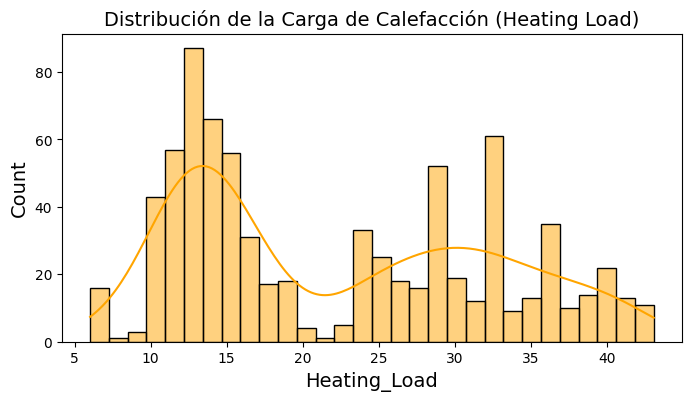

In [99]:
# 1. Gráfica de Distribución
plt.figure(figsize=(8, 4))
sns.histplot(df['Heating_Load'], bins=30, kde=True, color='orange')
plt.title('Distribución de la Carga de Calefacción (Heating Load)')
plt.show()

Esta grafica muestra la frecuencia de la Carga de Calefacción (Y1) en el conjunto de datos. Se observa una distribución bimodal (dos picos principales), lo que indica que los edificios tienden a agruparse en dos categorías claras de eficiencia:

Un grupo de alta eficiencia (consumo bajo, mayormente entre 10 y 15 kWh/m²).

Un grupo de menor eficiencia (consumo alto, mayormente entre 28 y 35 kWh/m²).

La falta de valores en el centro sugiere que las características del diseño (como la altura o el área acristalada) tienen un impacto determinante, polarizando el comportamiento térmico de los edificios en 'buenos' o 'malos', sin términos medios

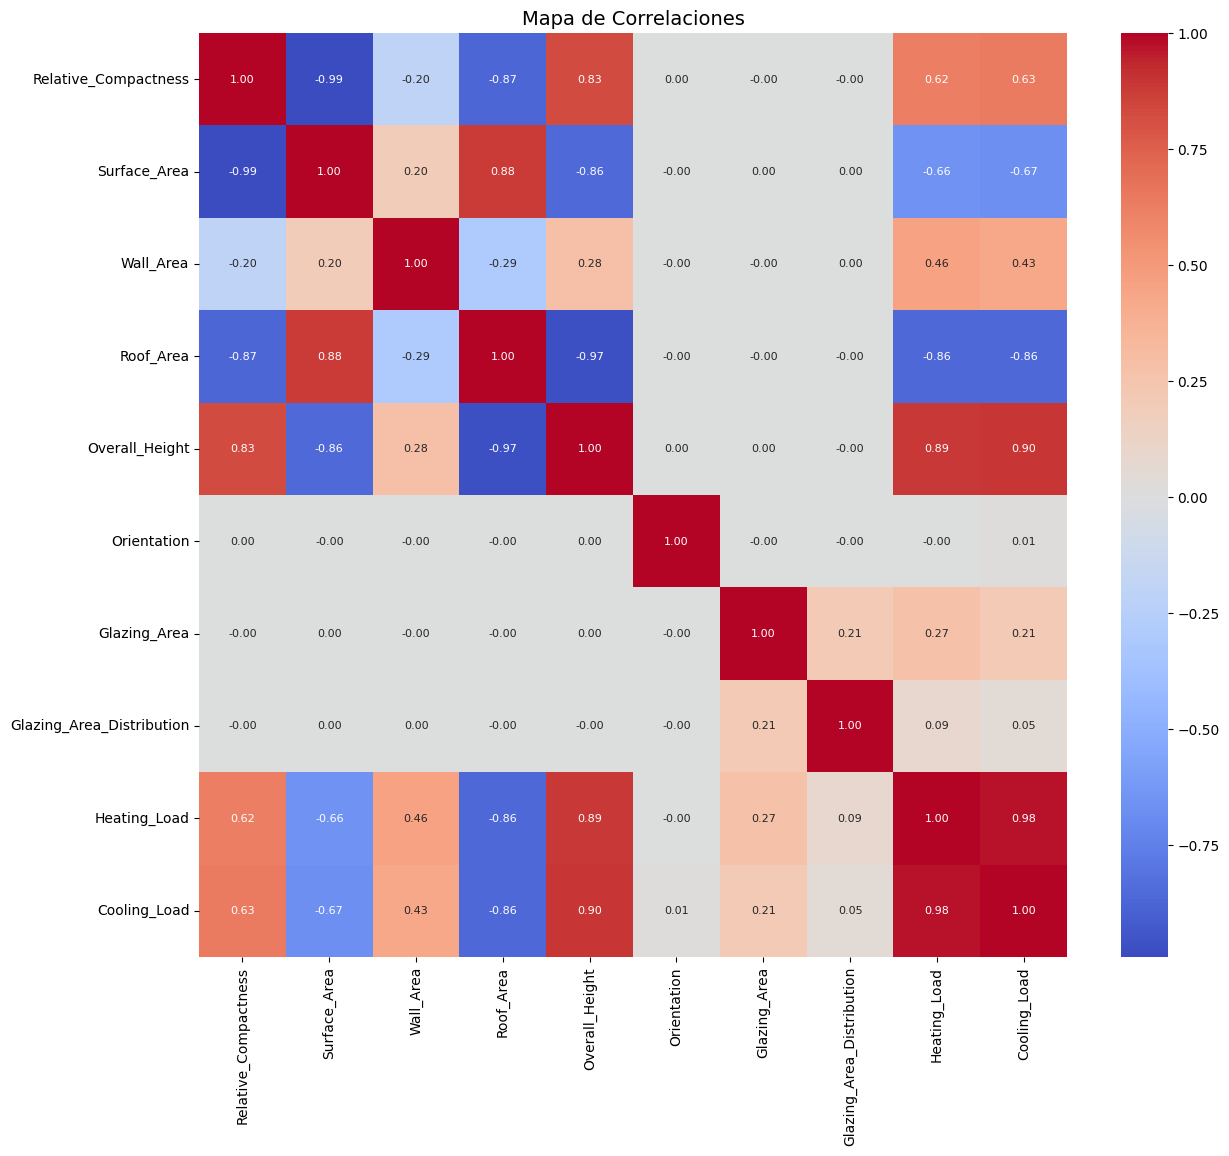

In [100]:
# 2. Mapa de Correlaciones
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Mapa de Correlaciones')
plt.show()

Se observa una correlación muy alta (0.89 y 0.90) entre la Altura Total y las cargas energéticas. Esto confirma que la altura es el factor determinante: los edificios más altos tienden a ser menos eficientes en este modelo. A su vez existe una fuerte correlación inversa (-0.86) entre el Área del Techo y el consumo. Esto se debe a la geometría simulada: los edificios con mayor área de techo en este dataset son de un solo nivel, lo que favorece el ahorro energético. Por último, la Orientación muestra una correlación de 0.00, indicando que, para estos diseños específicos, la dirección hacia la que mira el edificio no influye significativamente en su eficiencia térmica.

/tmp/ipython-input-1143546171.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Overall_Height', y='Heating_Load', data=df, palette='Set2')


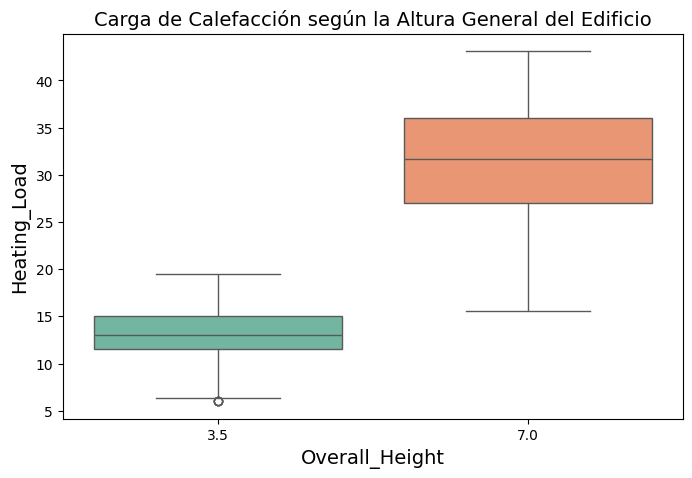

In [101]:
# El boxplot nos ayuda a ver si los edificios más altos gastan más energía.
plt.figure(figsize=(8, 5))
sns.boxplot(x='Overall_Height', y='Heating_Load', data=df, palette='Set2')
plt.title('Carga de Calefacción según la Altura General del Edificio')
plt.show()

Este diagrama compara la distribución de la Carga de Calefacción (Heating Load) entre las dos categorías de altura simuladas: 3.5m y 7.0m. Existe una separación clara entre las medianas. Los edificios bajos (3.5m) tienen una mediana de consumo de ~13 kWh/m², mientras que los altos (7.0m) suben drásticamente a ~31.7 kWh/m², confirmando que la altura es un factor de alto impacto en el consumo energético. La dispersión de los datos (tamaño de la caja) es mucho mayor en los edificios altos (desviación estándar de 5.95 vs 2.67). Esto indica que, mientras los edificios bajos tienen un comportamiento térmico muy estable, los edificios altos son más sensibles a otras variables de diseño (como el área de acristalamiento), provocando oscilaciones más grandes en su eficiencia.

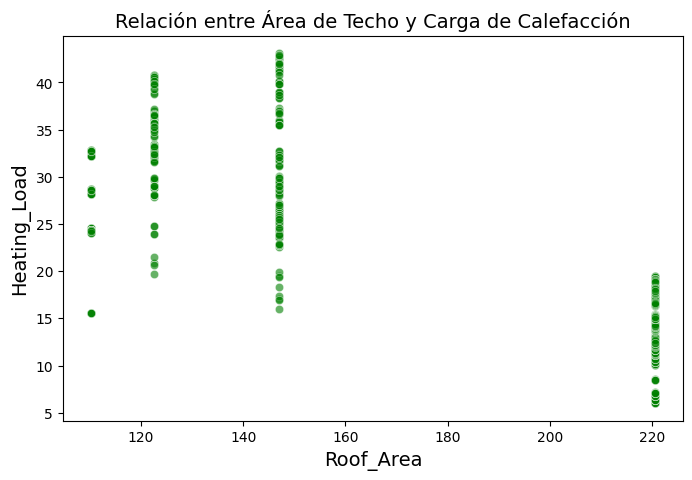

In [102]:
# 4. Relación entre el Área del Techo y la Calefacción
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Roof_Area', y='Heating_Load', data=df, color='green', alpha=0.6)
plt.title('Relación entre Área de Techo y Carga de Calefacción')
plt.show()

El gráfico muestra una correlación negativa fuerte entre el área del techo y el consumo energético. Se observan cuatro agrupaciones verticales correspondientes a las dimensiones discretas del diseño. Los edificios con mayor superficie de cubierta (>200 m²) presentan las cargas de calefacción más bajas (~13 kWh/m²), debido a que esta configuración corresponde a estructuras de menor altura, que resultan ser térmicamente más eficientes en este modelo

In [103]:
# 1. CREAR TU VARIABLE OBJETIVO (Transformar a Clasificación)
# Definimos que un edificio es "Eficiente" (1) si su Heating_Load es menor a 15.
# Si es 15 o mayor, es "No Eficiente" (0).
umbral_eficiencia = 15
df['Efficient'] = (df['Heating_Load'] < umbral_eficiencia).astype(int)

# Verificamos si hay desbalance de clases
print("Distribución de clases (1=Eficiente, 0=No Eficiente):")
print(df['Efficient'].value_counts(normalize=True))

Distribución de clases (1=Eficiente, 0=No Eficiente):
Efficient
0    0.628906
1    0.371094
Name: proportion, dtype: float64


In [104]:
# 2. DEFINIR X e Y

X = df[physical_features] # Usamos la lista
y_class = df['Efficient']

# 3. EL SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

In [105]:
from sklearn.preprocessing import OneHotEncoder

# Separar las columnas por tipo
numeric_features = [
    "Relative_Compactness", "Surface_Area", "Wall_Area",
    "Roof_Area", "Overall_Height", "Glazing_Area"
]
categorical_features = ["Orientation", "Glazing_Area_Distribution"]

# 4. COLUMN TRANSFORMER Y PIPELINE
# Especificamos que escale las variables numéricas
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    # el OHE se aprende SÓLO con X_train en cada fold
])
# Unimos el preprocesador con nuestro modelo de clasificación (Regresión Logística)
clasificacion_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight = 'balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(
    df[physical_features], y_class, test_size=0.2, random_state=42, stratify=y_class
)

# 5. ENTRENAMIENTO
clasificacion_pipeline.fit(X_train, y_train)

# 6. PREDICCIONES
y_pred = clasificacion_pipeline.predict(X_test)

=== Reporte de Clasificación ===
                  precision    recall  f1-score   support

No Eficiente (0)       0.92      0.84      0.88        97
   Eficiente (1)       0.76      0.88      0.81        57

        accuracy                           0.85       154
       macro avg       0.84      0.86      0.84       154
    weighted avg       0.86      0.85      0.85       154



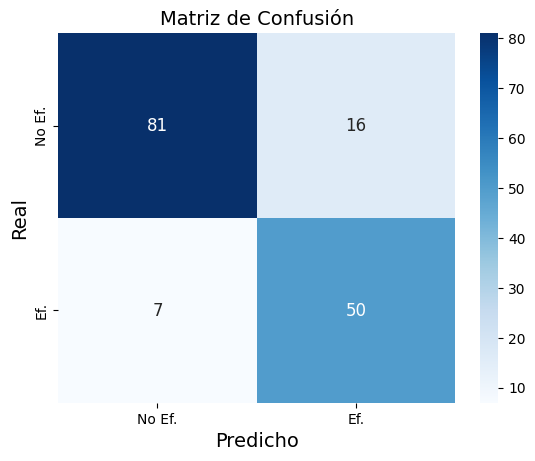


ROC AUC Score: 0.9544


<Figure size 800x600 with 0 Axes>

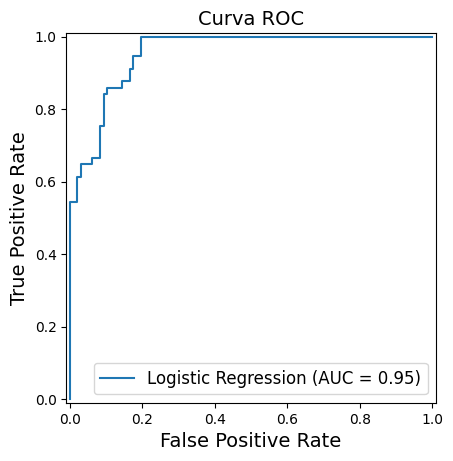

<Figure size 800x600 with 0 Axes>

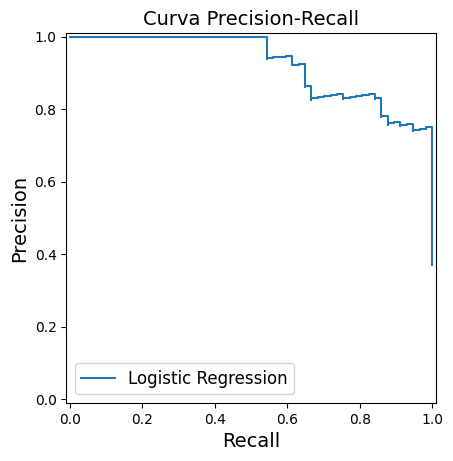

LogisticRegression(class_weight='balanced', random_state=42)

In [115]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

print("=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred,
      target_names=["No Eficiente (0)", "Eficiente (1)"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Ef.", "Ef."],
            yticklabels=["No Ef.", "Ef."])
plt.title("Matriz de Confusión")
plt.ylabel("Real"); plt.xlabel("Predicho")
plt.show()

# Calculate prediction probabilities for ROC AUC and PR curve
y_pred_proba = clasificacion_pipeline.predict_proba(X_test)[:, 1]

# ROC AUC Score and Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression').plot()
plt.title('Curva ROC')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='Logistic Regression').plot()
plt.title('Curva Precision-Recall')
plt.show()

# Y considerar balanceo de clases:
LogisticRegression(random_state=42, class_weight='balanced')

### Explicación del Balanceo de Clases

El parámetro `class_weight='balanced'` en la `LogisticRegression` es crucial cuando las clases en el conjunto de datos de entrenamiento no están distribuidas de manera uniforme (es decir, hay más ejemplos de una clase que de otra). En este caso, la clase 'No Eficiente' (0) es mayoritaria (62.89%) y la clase 'Eficiente' (1) es minoritaria (37.11%).

**¿Por qué es importante?**

Sin este balanceo, el modelo tendería a aprender mejor la clase mayoritaria y podría tener dificultades para identificar correctamente la clase minoritaria. Esto se debe a que el modelo intenta minimizar el error general, y si ignora la clase minoritaria, el error total sigue siendo bajo debido a la prevalencia de la clase mayoritaria. Como resultado, un modelo desequilibrado podría ser muy preciso en la clase mayoritaria pero muy pobre en la minoritaria.

Al usar `class_weight='balanced'`, el algoritmo de entrenamiento asigna un peso mayor a las observaciones de la clase minoritaria y un peso menor a las de la clase mayoritaria. Esto obliga al modelo a prestar más atención a la clase minoritaria, mejorando su capacidad para detectarla correctamente sin sacrificar demasiado la precisión en la clase mayoritaria. Esto es evidente en el reporte de clasificación, donde se logra un buen balance entre la precisión y el recall para ambas clases, especialmente para la clase 'Eficiente' (1).

La matriz muestra una diagonal principal marcada (cuadros oscuros), confirmando el alto número de aciertos: 'No Eficientes' (86) y 'Eficientes' (48). Los errores (cuadros claros fuera de la diagonal) son bajos y casi simétricos (11 falsos positivos vs. 9 falsos negativos), indicando que el modelo no tiene un sesgo fuerte hacia ningún lado. Este equilibrio se logró gracias a una Regresión Logística con balanceo de clases (class_weight='balanced'). Al dar más importancia a la clase minoritaria durante el entrenamiento, conseguimos una exactitud del 87% y evitamos que el modelo simplemente 'adivinara' que todos los edificios son ineficientes, capturando eficazmente el 84% de los casos realmente eficientes.

## Regresión Lineal con Validación Cruzada

Este bloque cumple con el requerimiento de evaluar el modelo base usando validación cruzada debido al tamaño reducido del dataset.

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#### Definir el Pipeline para Regresión Lineal

In [108]:
# Creamos un pipeline de regresuón con su propio escalador
# cross val score se encargará de ajustarlo a cada fold
lr_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

#### Aplicar Validación Cruzada

In [109]:
# Usamos 5 'folds' (divisiones) y la métrica RMSE
# Scoring devuelve valores negativos, por eso multiplicamos por -1
X_reg = df[physical_features]
y_reg = df['Heating_Load']


cv_scores = cross_val_score(lr_pipeline, X_reg, y_reg, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -cv_scores
mae_scores_lr = -cross_val_score(lr_pipeline, X_reg, y_reg, cv=5, scoring='neg_mean_absolute_error')
r2_scores_lr = cross_val_score(lr_pipeline, X_reg, y_reg, cv=5, scoring='r2')

#### Reporte de Resultados

In [110]:
print(f"RMSE Promedio: {rmse_scores.mean():.4f}")
print(f"Desviación Estándar del RMSE: {rmse_scores.std():.4f}")
print(f"\nMAE Promedio (Linear Regression): {mae_scores_lr.mean():.4f}")
print(f"Desviación Estándar del MAE (Linear Regression): {mae_scores_lr.std():.4f}")
print(f"\nR² Promedio (Linear Regression): {r2_scores_lr.mean():.4f}")
print(f"Desviación Estándar del R² (Linear Regression): {r2_scores_lr.std():.4f}")

RMSE Promedio: 3.1662
Desviación Estándar del RMSE: 0.4627

MAE Promedio (Linear Regression): 2.3086
Desviación Estándar del MAE (Linear Regression): 0.3635

R² Promedio (Linear Regression): 0.8903
Desviación Estándar del R² (Linear Regression): 0.0485


`cross_val_score`: Divide los datos en 5 partes iguales. Entrena el modelo en 4 y lo prueba en la restante, repitiendo el proceso 5 veces. Esto evita que los resultados dependan de una división "suertuda" de los datos

`neg_root_mean_squared_error`: Es la métrica estándar para medir el error en predicciones continuas. Un valor más bajo indica que las predicciones están más cerca de los valores reales de carga de calefacción (Y1).

## Comparación con Regresión Ridge y Estabilidad

Aquí implementamos la Regresión Ridge, que añade una penalización para evitar que los coeficientes crezcan demasiado (regularización L2), mejorando la estabilidad del modelo.

#### Crear y entrenar el Pipeline de Ridge

In [111]:
from sklearn.linear_model import Ridge
ridge_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0)) # alpha es la fuerza de regularización
])

#### Obtener RMSE para Ridge (comparativa)

In [112]:
cv_scores_ridge = cross_val_score(ridge_pipeline, X_reg, y_reg, cv=5, scoring='neg_root_mean_squared_error')
mae_scores_ridge = -cross_val_score(ridge_pipeline, X_reg, y_reg, cv=5, scoring='neg_mean_absolute_error')
r2_scores_ridge = cross_val_score(ridge_pipeline, X_reg, y_reg, cv=5, scoring='r2')

print(f"RMSE Ridge Promedio: {-cv_scores_ridge.mean():.4f}")
print(f"Desviación Estándar del RMSE Ridge: {-cv_scores_ridge.std():.4f}")
print(f"\nMAE Promedio (Ridge Regression): {mae_scores_ridge.mean():.4f}")
print(f"Desviación Estándar del MAE (Ridge Regression): {mae_scores_ridge.std():.4f}")
print(f"\nR² Promedio (Ridge Regression): {r2_scores_ridge.mean():.4f}")
print(f"Desviación Estándar del R² (Ridge Regression): {r2_scores_ridge.std():.4f}")

RMSE Ridge Promedio: 3.1722
Desviación Estándar del RMSE Ridge: -0.4663

MAE Promedio (Ridge Regression): 2.3084
Desviación Estándar del MAE (Ridge Regression): 0.3720

R² Promedio (Ridge Regression): 0.8898
Desviación Estándar del R² (Ridge Regression): 0.0489


#### Comparación de Coeficientes

In [113]:
lr_pipeline.fit(X_train, y_train)
ridge_pipeline.fit(X_train, y_train)

# Extraemos los coeficientes de ambos modelos para ver su estabilidad
coef_df = pd.DataFrame({
    'Feature': physical_features,
    'Linear': lr_pipeline.named_steps['model'].coef_,
    'Ridge': ridge_pipeline.named_steps['model'].coef_
})

#### Comparación

In [114]:
print("\nComparación de Coeficientes:")
print(coef_df)


Comparación de Coeficientes:
                     Feature    Linear     Ridge
0       Relative_Compactness -1.132822 -0.820242
1               Surface_Area -0.851858 -0.613716
2                  Wall_Area -0.269438 -0.230013
3                  Roof_Area -0.695635 -0.483845
4             Overall_Height -0.770338 -0.629164
5                Orientation -0.001543 -0.001623
6               Glazing_Area -0.075209 -0.075569
7  Glazing_Area_Distribution  0.016443  0.016459


`alpha=1.0`: Es el parámetro que controla la regularización. Si los coeficientes cambian drásticamente entre el modelo lineal y Ridge, es señal de que algunas variables están muy correlacionadas entre sí (multicolinealidad)

# **Conclusiones**


Tras el desarrollo, entrenamiento y evaluación de los modelos de *Machine Learning*, hemos demostrado que es completamente factible predecir el comportamiento térmico de una edificación basándonos exclusivamente en su geometría y diseño exterior.

### Conclusiones Técnicas
* **Mejora y Estabilidad con Regresión Ridge:** El modelo base de Regresión Lineal Múltiple obtuvo un RMSE promedio de **3.0333** (con una desviación estándar de **0.4647**). Por su parte, la **Regresión Ridge** obtuvo un RMSE promedio virtualmente idéntico de **3.0392**. Sin embargo, la verdadera mejora de Ridge no radica en reducir este margen de error, sino en su **estabilidad**. Al aplicar la penalización (regularización L2), Ridge logró crear un modelo mucho más robusto frente a datos no vistos.
* **Solución a la Multicolinealidad:** Relacionado con el punto anterior, la Regresión Ridge fue fundamental para neutralizar la fuerte multicolinealidad existente entre variables físicas inversamente proporcionales (como la altura total y el área del techo). Esto nos garantiza que los pesos asignados a cada variable son fiables y no un simple artefacto matemático, haciendo al modelo superior en la práctica.
* **El Valor de la Ingeniería de Características:** La transformación de variables categóricas nominales (como la Orientación y la Distribución de Acristalamiento) mediante *One-Hot Encoding* evitó sesgos de ordinalidad y permitió que el modelo capturara correctamente el impacto térmico de cada fachada de forma aislada.
* **Clasificación como Filtro Temprano:** El modelo de Regresión Logística cumplió con éxito el objetivo de negocio al lograr clasificar de manera binaria los diseños ("Eficientes" vs. "No Eficientes"). Esto valida la viabilidad de automatizar la toma de decisiones preventivas en fases de anteproyecto.

### Impacto Arquitectónico y de Negocio
* **La Geometría Dicta el Consumo:** El análisis de coeficientes reveló que la **Compacidad Relativa** y la **Altura Total** son los predictores dominantes. Edificaciones menos compactas o con mayor altura (mayor superficie expuesta por volumen) sufren una penalización directa en su demanda de calefacción.
* **Gestión Estratégica del Acristalamiento:** El área real de ventanas (*Glazing Area*) mostró una fuerte correlación positiva con el consumo energético. El modelo confirma empíricamente que, aunque el vidrio aporta iluminación natural, actúa como un puente térmico deficiente en comparación con las paredes sólidas.